In [65]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

from sklearn.metrics.cluster import adjusted_rand_score

import STAGATE_pyG

In [66]:
# # the location of R (used for the mclust clustering)
# os.environ['R_HOME'] = '/home/workspace2/zhaofangyuan/STAGATE'
# os.environ['R_USER'] = 'D:\ProgramData\Anaconda3\Lib\site-packages\rpy2'

In [67]:

adata = sc.read_h5ad('/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon/V1_Mouse_Brain_Sagittal_Posterior.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [68]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [69]:
# # read the annotation
# Ann_df = pd.read_csv(os.path.join('/home/workspace2/zhaofangyuan/STAGATE/Data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
# Ann_df.columns = ['Ground Truth']
# adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
# plt.rcParams["figure.figsize"] = (3, 3)
# sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

In [70]:
adata.obs_names

Index(['AAACAAGTATCTCCCA-1', 'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1',
       'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1',
       'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1', 'AAACCGGGTAGGTACC-1',
       'AAACCGTTCGTCCAGG-1',
       ...
       'TTGTGGCCCTGACAGT-1', 'TTGTGGTAGGAGGGAT-1', 'TTGTGTATGCCACCAA-1',
       'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1',
       'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1', 'TTGTTTCATTAGTCTA-1',
       'TTGTTTCCATACAACT-1'],
      dtype='object', length=3355)

------Calculating spatial graph...
The graph contains 19598 edges, 3355 cells.
5.8414 neighbors per cell on average.


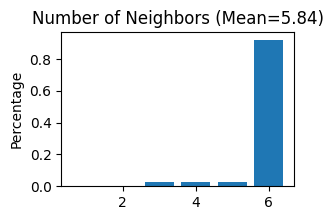

In [71]:
#Constructing the spatial network
STAGATE_pyG.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE_pyG.Stats_Spatial_Net(adata)

In [72]:
#Running STAGATE
adata = STAGATE_pyG.train_STAGATE(adata)


Size of Input:  (3355, 3000)


100%|██████████| 1000/1000 [00:13<00:00, 73.23it/s]


In [73]:
from sklearn import mixture

In [74]:

def mclust_P(adata, num_cluster, used_obsm='STAGATE', modelNames='EEE'):
    
    from sklearn import mixture
    np.random.seed(2020)
    g = mixture.GaussianMixture(n_components=num_cluster, covariance_type='diag')
    res = g.fit_predict(adata.obsm[used_obsm])
    adata.obs['mclust'] = res#预测的类别结果
    return adata

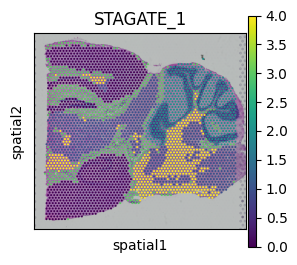

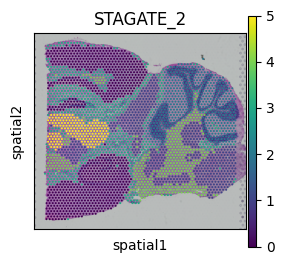

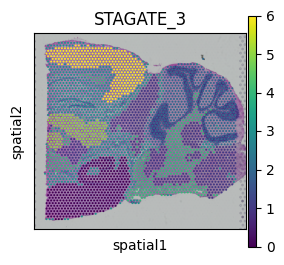

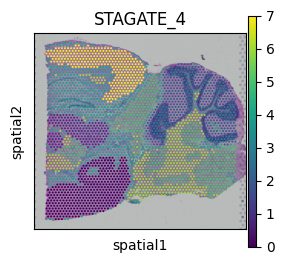

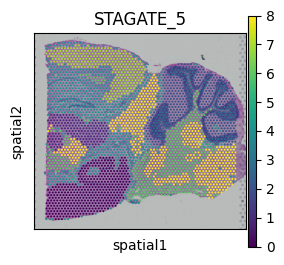

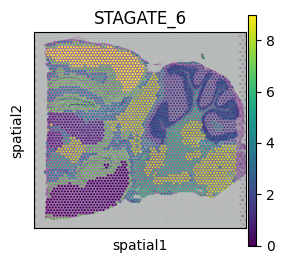

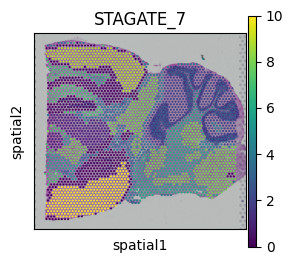

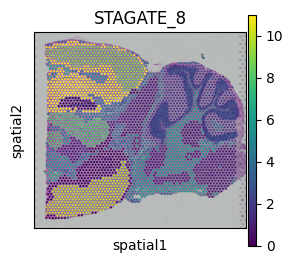

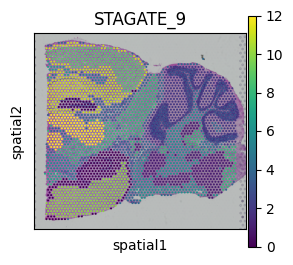

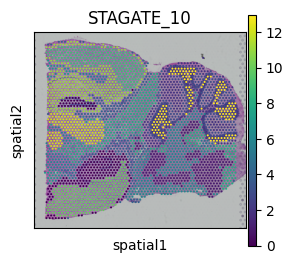

In [75]:
num_cluster_list=[5,6,7,8,9,10,11,12,13,14]
for i in range(10):
    adata_copy=adata.copy()
    sc.pp.neighbors(adata_copy, use_rep='STAGATE')
    sc.tl.umap(adata_copy)

    # adata = STAGATE_pyG.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)
    adata_copy = mclust_P(adata, used_obsm='STAGATE', num_cluster=num_cluster_list[i])

    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.spatial(adata_copy, color=["mclust"], title=['STAGATE_{}'.format(i+1)],show=False)
    plt.savefig(f'./output/stagate_{i+1}.jpg', bbox_inches='tight', dpi=150)
    
    adata.obs['stagate_mclust_{}'.format(i+1)]=adata_copy.obs['mclust']

adata.write(f'./STAGATE_V1_Mouse_Brain_Sagittal_Posterior(resolution).h5ad')

In [76]:
# obs_df = adata.obs.dropna()
# ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
# print('Adjusted rand index = %.2f' %ARI)